In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
import time

%matplotlib inline
import psycopg2  # DB connectivity library

from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Functions and Classes
These are our collection of functions and classes that we use in this project.

## EDA Class
This class will assist with exploratory data analysis, by curating, and reporting a comprehensive list of metadata 
about our dataset.

## ColumnSelector Class
This class will be used with a pipeline, so it can be used for cleaning and transforming columns.

In [33]:
class EDA():
    # This class requires pandas

    def __init__(self, adfData):
        # Assign the instance dfData variable with the dfData argument.
        self.dfData = adfData

        # Put the describe results in an instance variable (dataframe)
        self.dfDescribe = self.dfData.describe()

        # Get the number of rows and columns in the resulting dataframe (after nulls have been removed, if required)
        # and put the values in the numrows and numcols attributes.
        self.numrows = self.dfData.shape[0]
        self.numcols = self.dfData.shape[1]

        # Get the datatype counts for each column.  dfData's column names will be the index of the dataframe, and the
        # data type counts will be in the only column, 'Freq'
        self.dfDTypeCounts = pd.DataFrame(self.dfData.get_dtype_counts(), columns=['Freq'])

        # Get the datatypes for each column.  dfData's column names will be the index of the dataframe, and the data type
        # will be in the only column, 'Type'
        self.dfDtypes = pd.DataFrame(data=self.dfData.dtypes, columns=['Type'])
        
        self.dfInfo = self.dfData.info()
    
    def printSummary(self):
        # This function will print out a number of statistical information on the data,
        # as well as metadata on the data, which can all be used in evaluation and 
        # cleaning of the dataset.
        print '|====================================================================|'
        print '|                                EDA                                 |'
        print '|====================================================================|'
        print '| Date:  ' + (time.strftime("%d/%m/%Y")) + ' at ' + (time.strftime("%H:%M:%S"))
        print '|====================================================================|'
        print '|                               SHAPE                                |'
        print '| # ROWS:  ' + str(self.dfData.shape[0]) + ';  # COLUMNS: ' + str(self.dfData.shape[1])
        print '|====================================================================|'
        print '|                            COLUMN TYPES                            |'
        print self.dfDtypes
        print '|====================================================================|'
        print '|                         COLUMN TYPE COUNTS                         |'
        print self.dfDTypeCounts
        print '|====================================================================|'
        print '|                               INFO                                 |'
        print self.dfData.info(verbose=True,null_counts=True)
        print '|====================================================================|'
        print '|                              DESCRIBE                              |'
        print self.dfDescribe
        print '|====================================================================|'
        # Pairplot



class ColumnSelector(BaseEstimator, TransformerMixin):
    # This class requires Pandas
    
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
        else:
            raise TypeError("This transformer only works with Pandas Dataframes")
    
    def fit(self, X):
        return self

class BaseModelAnalyzer():
    # This class will be the base class, which will be used by subsequent children classes, that will offer 
    # functionality to assist with analysis of different Scikit Learn predictive models.
    
    def __init__(self, aModel):
        self.Model = aModel

class LogisticRegressionAnalyzer(BaseModelAnalyzer):
    # This class requires pandas and numpy
    
    def printSummary(self, X, y, columns):
        print '|====================================================================|'
        print '|                    MODEL EVALUATOR - SUMMARY                       |'
        print '|====================================================================|'
        print '| Model Type: Logistic Regression                                    |'
        print '| Date:  ' + (time.strftime("%d/%m/%Y")) + ' at ' + (time.strftime("%H:%M:%S"))
        print '|====================================================================|'
        print '|                           COEFFICIENTS                             |'
        counter=0
        for coef in self.Model.coef_[0]:
            if (columns == '') :
                label = str(counter + 1)
            else:
                label = '('+columns[counter]+')'
            print '| Coefficient ' + label + ': ' + str(coef)
            counter+=1
        print '|====================================================================|'
        print '|                           Y-INTERCEPT                              |'
        print '| ' + str(self.Model.intercept_[0])
#         print self.Model.n_iter_  # Need this later?
        print '|====================================================================|'
        print '|                              SCORE                                 |'
        # Get the score of the model
        print '| ' + str(self.Model.score(X,y))
        print '|====================================================================|'
    
    def printTestSummary(self,X_test, y_test):
        print '|====================================================================|'
        print '|                  MODEL EVALUATOR - TEST SUMMARY                    |'
        print '|====================================================================|'
        print '| Model Type: Logistic Regression                                    |'
        print '| Date:  ' + (time.strftime("%d/%m/%Y")) + ' at ' + (time.strftime("%H:%M:%S"))
        print '|====================================================================|'
        print '|                        TEST DATA STATS                             |'
        print '| Length of Test Data: ' + str(len(X_test))
        print '|====================================================================|'
        print '|                       TEST DATA RESULTS                            |'
        predictions = self.Model.predict(X_test)
        predictionsProba = self.Model.predict_proba(X_test)
        dfResultsCompare = pd.DataFrame(data={'Predictions':np.array(predictions),
                                'Target':np.array(y_test),
                                'HitOrMiss':[1 if (predictions[x] == np.array(y_test)[x]) else 0 for x in range(len(predictions))],
                                'PredictionsProba-0':np.array(np.transpose(predictionsProba)[0]),
                                'PredictionsProba-1':np.array(np.transpose(predictionsProba)[1])},
                                       columns = ['Predictions','Target','HitOrMiss','PredictionsProba-0','PredictionsProba-1'])

        return dfResultsCompare  # Returns the test results in a dataframe

## Pre-Task: Describe the goals of your study

Using data from the Titanic disaster, we want to be able to predict who is likely to survive or perish in a ship disaster.


## Part 1: Aquire the Data

#### 1. Connect to the remote database

In [3]:
# Connect to the database using the following authentication information:
# psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
# password: gastudents
conn = psycopg2.connect('host=dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com dbname=titanic user=dsi_student password=gastudents port=5432')

#### 2. Query the database and aggregate the data

In [4]:
# Get a list of the tables
sqlQuery = 'select * from train;'
dfTitanic = pd.read_sql_query(sqlQuery,con=conn, index_col='index')
dfTitanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
index,,,,,,,,,,,,
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,None,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,None,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,None,S


## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

## Using our EDA class, create an instance, and then print the summary report

In [5]:
edaEng = EDA(dfTitanic)
edaEng.printSummary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB
|====================================================================|
|                                EDA                                 |
|====================================================================|
| Date:  10/07/2016 at 10:18:40
|====================================================================|
|                               SHAPE                                |
| # ROWS:  891;  # COLUMNS: 

## Survived
Because we will be predicting Survived, let's take a closer look at those values.

Survived is a numerical boolean value, with ** 1 = Survived and 0 = Perished. **
When we exame the INFO section of the above EDA report, we see that there are 891 non-null values, which is the same
total number of rows - which mean there are no null values in this column.

** Let's find out a baseline for Survived: **

In [6]:
dfTitanic['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

## PassengerId
A visual inspection of the data will quickly yield the realization that the Passenger ID is a unique identifier.
Because of this, there should be no correlation with any of the other variables.  We will exclude Passenger ID as one of our features for modeling

** FUTURE ACTION:  Exclude PassengerId from features for modeling. **

## Pclass
The Passenger Class (Pclass) contains categorical values:  1 - 1st Class; 2 - 2nd Class; 3 - 3rd Class.
We will want to convert this categorical data into dummy columns in the future.

** FUTURE ACTION: Make Pclass into dummy columns, and include in our features for modeling. **

## Name
This is the name of each passenger.  It is not relevant to our modeling, so we should exclude it from the features list.

** FUTURE ACTION:  Exclude Name from features for modeling. **

## Sex
A visual inspection of the data will quickly yield the realization that the Sex column appears to contain the values 'female' and 'male'.  Let's confirm that...

In [7]:
dfTitanic['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Yup!  That means we will want to conver this categorical data into dummy variables, and include them in our features for modeling.

** FUTURE ACTION: Make Sex into dummy columns, and include in our features for modeling. **

## Age
Upon inspection of the INFO section of the above EDA report, we see that Age has 714 non-null values, whereas there
are a total of 891 rows.  This means that there are 177 null-type values in this column.

If we take a look at the Age data in the dataframe at the top, we do in fact see NaN values in several rows.  It appears 
however, that this is the only null value in the row.  We can replace them using an Imputer function from Scikit Learn,
which we will do later on.

** FUTURE ACTION: Replace the nulls in the Age column, with the most frequent Age. ** 

## SibSp

SibSp is the number of siblings/spouses aboard, and it is a numerical value.

** FUTURE ACTION:  Include SibSp in our features for modeling. **

## Parch

Number of parents/children aboard, and it is a numerical value.

** FUTURE ACTION: Include Parch in our features for modeling. **

## Ticket

This data does not have a consistent format, and the values are alphanumeric.  It is not categorical data either.  This information should not be included in our modeling.

** FUTURE ATION: Exclude Ticket from features for modeling. **

## Fare
Continuous numerical data - that's what we like!

** FUTURE ACTION:  Include Fare in our features for modeling. **

## Cabin
Upon inspection of the INFO section of the above EDA report, we see that Cabin has ** 204 non-null values, ** whereas there are
a ** total of 891 rows. **  This means that there are ** 687 null-type values in the Cabin column. **  This is a lot of null values - 
how do we handle them?

Let's exploare the data further for clues...  A visual inspection of the Cabin data shows that these are the cabin names/
numbers, but the data is rather inconsistent.  It is also not numerical, and not categorical.  It appears that this column
should be left out of our modeling.

** FUTURE ACTION: Remove the Cabin column from the modeling data. **

## Embarked
Upon inspection of the INFO section of the above EDA report, we see that Embarked has 889 non-null values, whereas there 
are a total of 891 rows.  This means that there are 2 null-type values in the Embarked columns.

Let's look at these 2 rows with the null values in the Embarked column.

In [8]:
dfTitanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
sqlQuery = 'select * from train where "Embarked" is null;'
dfResults = pd.read_sql_query(sqlQuery,con=conn)
dfResults

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,None
1,829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,None


With just 2 records having null values in the Embarked column, go ahead and remove this two columns.

** FUTURE ACTION:  Remove these 2 rows from training data. **

#### 2. Visualize the Data

# Explore Data Behavior
Explore data distributions and relationships between the features.

## Histograms for Age, by Pclass
We see that in 1st class, the distribution of ages is fairly evenly distributed.  But in 2nd class, we begin to see the 
distribution of the ages shift to younger ages, finishing up with 3rd class consisting of a comparatively young population.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a49fbd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ca18790>]], dtype=object)

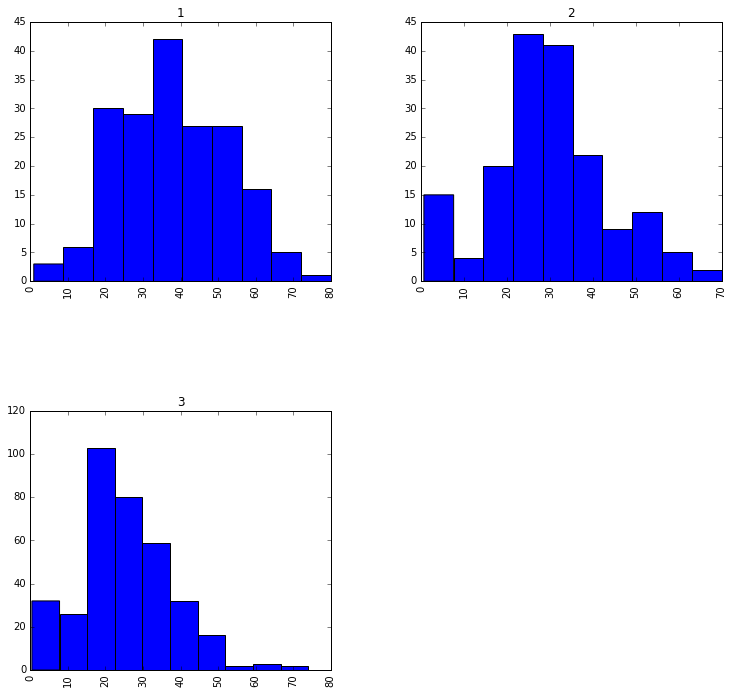

In [10]:
dfTitanic.hist('Age',by='Pclass',figsize=(12,12))



## Histograms for Age, by Sex
As can be seen from the histograms below, there are far more men than women traveling.  Their distributions are very
similar, with the exception of the 0-10 years age group.  Why is that?

Upon reflection, I realized that at this time in history, it was likely that the vast majority of women traveling on a ship would
be doing so with a spouse, or other male family member.  On the flip side, it would certainly be acceptable for a man to
travel without a female companion.  This explains why there are more men than women.

But in the 0-10 age group, why are the number of males and females the same?  Well we can certainly expect that anyone under
the age of 10 that would be traveling on a ship, would be doing so with their family - whether that child was male or female.  
And there are no "social laws" that make it more preferential to bring male children along on the cruise, over female children.
So if families are bringing their young children, then because of the [generally] 50/50 distribution of gender among the
population, it is reasonable to see these counts are very similar.

Also of interest is that the female group doesn't have any passengers over 69, but the men have quite a few passengers
in those age groups.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1194de210>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11d6461d0>], dtype=object)

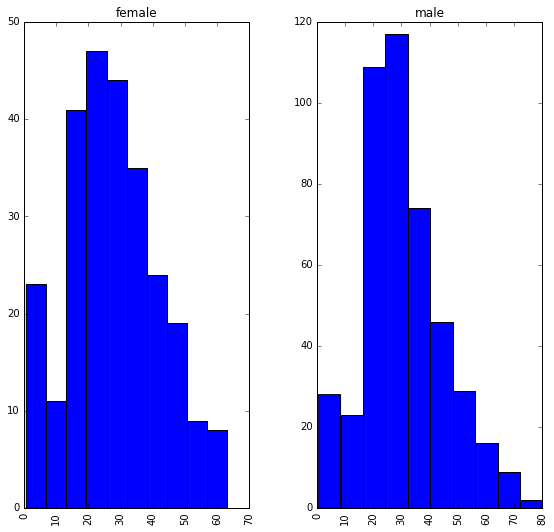

In [11]:
dfTitanic.hist('Age',by='Sex',figsize=(9,9))

## Histograms for Pclass, by Survived


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a4aacd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11da8aed0>], dtype=object)

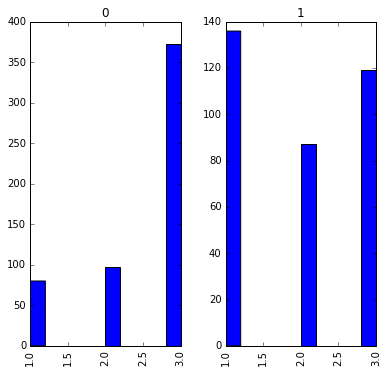

In [12]:
dfTitanic.hist('Pclass',by='Survived',figsize=(6,6))

## Histograms for Survived, by Sex
In this distribution of those who survived Titanic's sinking, and those who perished, we see that there are more than
twice as many women that survived, versus the men.  That is quite interesting, considering that earlier we noted that
the number of female passengers was about half of the number of male passengers.

So it could be suggested that due to the "women and children first" 'rule', a disproportionate number of female passengers
survived, compared to the males.  In fact, the number of women who perished, is less than the number of men that survived.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a443390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11df381d0>], dtype=object)

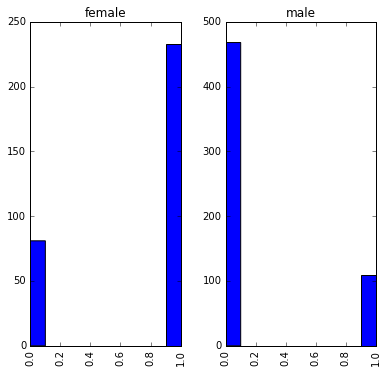

In [13]:
dfTitanic.hist('Survived',by='Sex',figsize=(6,6))

## Histogram for Age, by Survived

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e026410>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11e174dd0>], dtype=object)

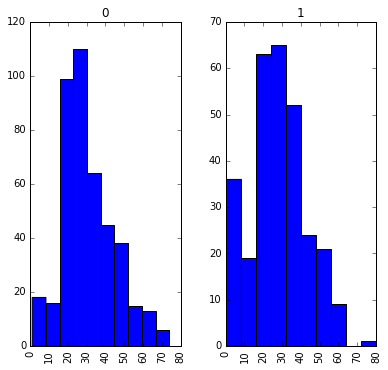

In [14]:
dfTitanic.hist('Age',by='Survived',figsize=(6,6))

#### 5. What are the risks and assumptions of our data? 

## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex* 

## Data Cleaning & Transforming To Do List
In our previous exploration of the data, we identified a number of actions that we need to take to prepare the data for modeling:

* ** CABIN: ** Remove the Cabin column.
* ** EMBARKED: ** Remove the two rows with the null values.
* ** AGE: ** Replace the nulls in the Age column, with the most frequent Age.
* ** PCLASS: ** Make into dummy columns.
* ** SEX: ** Make into dummy columns.
* ** 

### So let's get going then, lazybones!

### Cabin
Let's begin by removing the Cabin column.

In [15]:
dfTitanic = dfTitanic.drop(labels='Cabin', axis=1)
dfTitanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
index,,,,,,,,,,,
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


### Age
For the Age values that are null, replace the null with the most frequent Age value.

In [16]:
freqAge = dfTitanic['Age'].value_counts().index[0]
print 'The most frequent Age is ' + str(freqAge)
dfTitanic['Age'] = [freqAge if (np.isnan(x) == True) else x for x in dfTitanic['Age']]

The most frequent Age is 24.0


Check the non-null values of Age, and compare to the total row numbers.

In [17]:
dfTitanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.5+ KB


Now Age has 891 non-null values, and there are 891 rows.  Good!

### Embarked
Now, drop the null rows - this will remove the two rows where the Embarked values are null.

In [18]:
print 'BEFORE  # Rows: ' + str(dfTitanic.shape[0]) + ';  # Columns: ' + str(dfTitanic.shape[1])
dfTitanic.dropna(inplace=True)
print 'AFTER  # Rows: ' + str(dfTitanic.shape[0]) + ';  # Columns: ' + str(dfTitanic.shape[1])

BEFORE  # Rows: 891;  # Columns: 11
AFTER  # Rows: 889;  # Columns: 11


Yahoo!  There go those pesky 2 null rows.  Now, we should have NO null values left in our table.  Let's check:

In [19]:
dfTitanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


Looking good!  Our total number of rows is 889, and all of our columns, each have 889 non-null values.

Let's take a peek at our dataframe now.

In [20]:
dfTitanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
index,,,,,,,,,,,
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",male,24.0,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S


Let's save our prepped data before we continue on to our modeling.

In [21]:
dfTitanic.to_csv('TitanicClean.csv')

## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

For our features, we will use the columns:

In [36]:
Xmatrix = dmatrix('~ C(Pclass) + C(Sex) + (Age) + (SibSp) + (Parch) + C(Embarked) + 0', dfTitanic)

In [37]:
Xmatrix

DesignMatrix with shape (889, 9)
  Columns:
    ['C(Pclass)[1]',
     'C(Pclass)[2]',
     'C(Pclass)[3]',
     'C(Sex)[T.male]',
     'C(Embarked)[T.Q]',
     'C(Embarked)[T.S]',
     'Age',
     'SibSp',
     'Parch']
  Terms:
    'C(Pclass)' (columns 0:3)
    'C(Sex)' (column 3)
    'C(Embarked)' (columns 4:6)
    'Age' (column 6)
    'SibSp' (column 7)
    'Parch' (column 8)
  (to view full data, use np.asarray(this_obj))

I find it interesting that patsy's dmatrix function did not create a 'C' column for the Embarked column, and it also didn't create a Female column for the Sex class.  But let's try it out and see what happens.

In [38]:
featureCols = ['Pclass_1','Pclass_2','Pclass_3','Sex_male','Embarked_Q','Embarked_S','Age','SibSp','Parch']

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

We want to predict whether a passenger survived or perished, so we will use the 'Survived' column as our Y column.

In [39]:
Target = np.array(dfTitanic['Survived'])

** 2a. Create our test and training data. **

In [40]:
X_train, X_test, y_train, y_test = train_test_split(Xmatrix, Target, test_size=0.33, random_state=42)
print 'X_train Shape: ' + str(X_train.shape)
print 'X_test Shape: ' + str(X_test.shape)
print 'y_train Shape: ' + str(y_train.shape)
print 'y_test Shape: ' + str(y_test.shape)

X_train Shape: (595, 9)
X_test Shape: (294, 9)
y_train Shape: (595,)
y_test Shape: (294,)


#### 3. Conduct the logistic regression

In [41]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 4. Examine the coefficients to see our correlations

In [42]:
lra = LogisticRegressionAnalyzer(lr)
lra.printSummary(X_train, y_train, featureCols)

|====================================================================|
|                    MODEL EVALUATOR - SUMMARY                       |
|====================================================================|
| Model Type: Logistic Regression                                    |
| Date:  10/07/2016 at 11:22:09
|====================================================================|
|                           COEFFICIENTS                             |
| Coefficient (Pclass_1): 1.61259154225
| Coefficient (Pclass_2): 0.863277084182
| Coefficient (Pclass_3): -0.384107015469
| Coefficient (Sex_male): -2.43058746073
| Coefficient (Embarked_Q): -0.25492913169
| Coefficient (Embarked_S): -0.487485557635
| Coefficient (Age): -0.0319659150357
| Coefficient (SibSp): -0.31355765218
| Coefficient (Parch): 0.00231728346466
|====================================================================|
|                           Y-INTERCEPT                              |
| 2.09176161096
|================

** Let's take a look at the coefficients: **



#### 6. Test the Model by introducing a *Test* or *Validaton* set 

In [28]:
# predictions = lr.predict(X_test)
#  Wait for it...

#### 7. Predict the class labels for the *Test* set

In [29]:
#  ...keep waiting...

#### 8. Predict the class probabilities for the *Test* set

In [30]:
# ...be patient a little while longer...

#### 9. Evaluate the *Test* set

In [31]:
#  You were so patient!  Here is what you asked for:
dfTestResults = lra.printTestSummary(X_test, y_test)
dfTestResults

|====================================================================|
|                  MODEL EVALUATOR - TEST SUMMARY                    |
|====================================================================|
| Model Type: Logistic Regression                                    |
| Date:  10/07/2016 at 10:18:44
|====================================================================|
|                        TEST DATA STATS                             |
| Length of Test Data: 294
|====================================================================|
|                       TEST DATA RESULTS                            |


,Predictions,Target,HitOrMiss,PredictionsProba-0,PredictionsProba-1
0,0,0,1,0.886648,0.113352
1,1,1,1,0.149692,0.850308
2,1,1,1,0.319409,0.680591
3,0,0,1,0.716384,0.283616
4,1,1,1,0.123090,0.876910
5,0,1,0,0.886648,0.113352
6,0,0,1,0.716384,0.283616
7,0,0,1,0.886648,0.113352
8,1,1,1,0.088025,0.911975
9,1,1,1,0.071560,0.928440


#### 10. Cross validate the test set

#### 11. Check the Classification Report

#### 12. What do the classification metrics tell us?

#### 13. Check the Confusion Matrix

#### 14. What does the Confusion Matrix tell us? 

#### 15. Plot the ROC curve

#### 16. What does the ROC curve tell us?

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [32]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

#### 5. [BONUS] Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?

#### 6.a. [BONUS] You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### [BONUS] Why?

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

#### 7. [BONUS] Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

## Part 7: [BONUS] Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

## Part 8: [VERY BONUS] Decision trees, ensembles, bagging

#### 1. Gridsearch a decision tree classifier model on the data, searching for optimal depth. Create a new decision tree model with the optimal parameters.

#### 2. Compare the performace of the decision tree model to the logistic regression and kNN models.

#### 3. Plot all three optimized models' ROC curves on the same plot. 

#### 4. Use sklearn's BaggingClassifier with the base estimator your optimized decision tree model. How does the performance compare to the single decision tree classifier?

#### 5. Gridsearch the optimal n_estimators, max_samples, and max_features for the bagging classifier.

#### 6. Create a bagging classifier model with the optimal parameters and compare it's performance to the other two models.